In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
import os

# Folders
folder0 = "data/Y9 updated/"
folder1 = "data/Y9 update2/"

# Loading raw data for comparison
X0 = pd.read_csv(os.path.join(folder0, "ORAL ASSESSMENT Y9 ALL export3.csv"), header=None, index_col=0)
X1 = pd.read_csv(os.path.join(folder1, "ORAL ASSESSMENT Y9 ALL export4.csv"), header=None, index_col=0)

# Strip leading single quotes from indices to ensure matching
X0.index = X0.index.astype(str).str.lstrip("'")
X1.index = X1.index.astype(str).str.lstrip("'")

# Align columns for comparison
X1.columns = X0.columns

print(f"Input shapes: X1={X1.shape}, X0={X0.shape}, no missing {X1.isna().sum().sum()}/{X0.isna().sum().sum()}")

In [ ]:
# Compare X0 and X1 row by row and print discrepancies
print("--- Row by row comparison (X0 vs X1) ---")
common_idx = X0.index.intersection(X1.index)
common_cols = X0.columns.intersection(X1.columns)

discrepancies_found = 0
for idx in common_idx:
    row0 = X0.loc[idx, common_cols]
    row1 = X1.loc[idx, common_cols]
    
    if not row0.equals(row1):
        mask = (row0 != row1) & ~(row0.isna() & row1.isna())
        if mask.any():
            discrepancies_found += 1
            diff_cols = common_cols[mask]
            print(f"Row {idx} discrepancies in columns: {list(diff_cols)}")
            for col in diff_cols:
                val0 = row0[col]
                val1 = row1[col]
                if pd.isna(val0) != pd.isna(val1):
                    type_str = " (Value vs NaN)"
                else:
                    type_str = " (Value Change)"
                print(f"  Col {col}: X0={val0}, X1={val1}{type_str}")

if discrepancies_found == 0:
    if len(common_idx) == 0:
        print("No overlapping index found to compare.")
    else:
        print("No row-by-row discrepancies found in aligned indices/columns.")
else:
    print(f"\nTotal rows with discrepancies: {discrepancies_found}")

In [ ]:
# Read theta and beta estimates
beta0 = pd.read_csv(os.path.join(folder0, "beta_all_methods.csv"), index_col=0)
beta1 = pd.read_csv(os.path.join(folder1, "beta_all_methods.csv"), index_col=0)
theta0 = pd.read_csv(os.path.join(folder0, "theta_all_methods.csv"), index_col=0)
theta1 = pd.read_csv(os.path.join(folder1, "theta_all_methods.csv"), index_col=0)

# Strip leading single quotes from indices to ensure matching (same as with X0 and X1)
for df in [beta0, beta1, theta0, theta1]:
    df.index = df.index.astype(str).str.lstrip("'")

print(f"\nLoaded estimates from {folder0} and {folder1}")
print(f"Theta common indices: {len(theta0.index.intersection(theta1.index))}/{len(theta0)}")

In [ ]:
def calculate_correlations(df0, df1, label):
    print(f"\n--- {label} Correlations (Old vs New) ---")
    common_cols = df0.columns.intersection(df1.columns)
    
    results = []
    for col in common_cols:
        common_idx = df0.index.intersection(df1.index)
        v0 = df0.loc[common_idx, col]
        v1 = df1.loc[common_idx, col]
        
        pearson = v0.corr(v1)
        spearman, _ = spearmanr(v0, v1)
        
        print(f"{col:20s}: Pearson = {pearson:.4f}, Spearman = {spearman:.4f}")
        results.append({"Method": col, "Pearson": pearson, "Spearman": spearman})
    
    return pd.DataFrame(results)

beta_corr = calculate_correlations(beta0, beta1, "Beta")
theta_corr = calculate_correlations(theta0, theta1, "Theta")

Theta outliers (> 2.5 sigma): ['02C530']


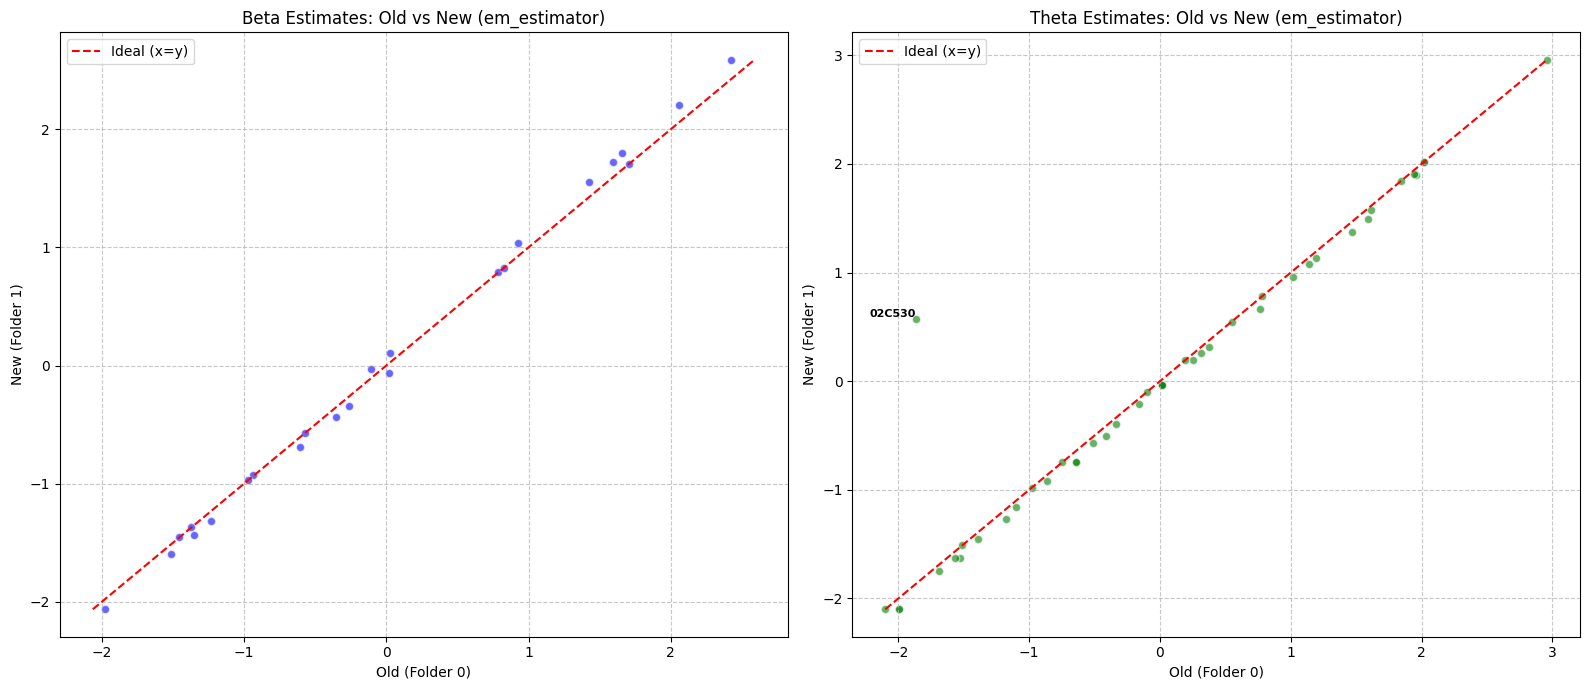

In [46]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7))
method = 'em_estimator'

def plot_with_outlier_labels(ax, df0, df1, method, label_prefix, color='blue', threshold=2.5):
    common_idx = df0.index.intersection(df1.index)
    x = df0.loc[common_idx, method]
    y = df1.loc[common_idx, method]
    
    ax.scatter(x, y, alpha=0.6, color=color, edgecolors='w')
    
    # Calculate residuals from y=x trend line
    residuals = y - x
    std_res = residuals.std()
    
    # Identify outliers
    outlier_mask = residuals.abs() > threshold * std_res
    outliers = common_idx[outlier_mask]
    
    # Label each outlier with its index
    for idx in outliers:
        ax.text(x.loc[idx], y.loc[idx], str(idx), fontsize=8, fontweight='bold', 
                verticalalignment='bottom', horizontalalignment='right')
    
    if len(outliers) > 0:
        print(f"{label_prefix} outliers (> {threshold} sigma): {list(outliers)}")

    # Baseline y=x
    min_val = min(x.min(), y.min())
    max_val = max(x.max(), y.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal (x=y)')
    
    ax.set_title(f'{label_prefix} Estimates: Old vs New ({method})')
    ax.set_xlabel('Old (Folder 0)')
    ax.set_ylabel('New (Folder 1)')
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend()

# Beta Scatter
plot_with_outlier_labels(axes[0], beta0, beta1, method, 'Beta', color='blue')

# Theta Scatter
plot_with_outlier_labels(axes[1], theta0, theta1, method, 'Theta', color='green')

plt.tight_layout()
plt.show()